# Modelling

<br>

## The main objectives for this notebook are:
* To assess the prevalence and severity of household food insecurity.
* To examine the influence of socioeconomic and demographic factors on household food insecurity.
* To analyze the impact of agricultural activities on household food security.
* To investigate the association between exposure to shocks (drought, flooding, violence, conflicts) and household food insecurity.
* To identify potential interventions and policy recommendations to mitigate food insecurity and enhance household resilience.


**Research Questions**:
* What is the prevalence and severity of household food insecurity?
* How do socioeconomic and demographic factors (e.g., income, education, household size) influence household food insecurity?
* What is the relationship between agricultural activities (e.g., crop production, livestock rearing) and household food security?
* How does exposure to shocks, such as drought, flooding, violence, and conflicts, affect household food insecurity?

## Prevalence and predictors of food insecurity among household in 5 northern states in Nigeria

**Different Model to try**

* logistic regression,
* probit regression, or Tobit regression with raw score as dependent variable.
* linear probability (OLS with a 0/1 dependent variable)
* Three level linear model

- Engineer a new feature `received_need`
- Engineer a binary dependent variable `fies_cat`



## Import Libraries and Data

In [1]:
## Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import statsmodels as sm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_row', 500)

In [2]:
# Import the data into a DataFrame

df_original = pd.read_csv("../data/26052024_model_ready_data")

**Design matrices (endog & exog)**

To fit most of the models covered in `statsmodel`, you will need to create two design matrices.
- The first is a matrix of endogenous variable(s) (i.e. dependent, response, regressand, etc.).
- The second is a matrix of exogenous variable(s) (i.e. independent, predictor, regressor, etc.).


In [3]:
# Output the first 5 rows 
df_original.head()

,country,state,local_govt_area,hh_agricactivity,hh_gender,hh_education,hh_size,hh_maritalstat,hh_age,resp_islsproducer,resp_iscropproducer,resp_isfishproducer,weight_final,hh_wealth_water,hh_wealth_toilet,hh_wealth_light,income_main,income_main_gender,income_main_comp,income_sec,income_third,shock_noshock,shock_sicknessordeathofhh,shock_lostemplorwork,shock_otherintrahhshock,shock_higherfoodprices,shock_higherfuelprices,shock_mvtrestrict,shock_othereconomicshock,shock_pestoutbreak,shock_plantdisease,shock_animaldisease,shock_napasture,shock_othercropandlivests,shock_coldtemporhail,shock_flood,shock_hurricane,shock_drought,shock_earthquake,shock_landslides,shock_firenatural,shock_othernathazard,shock_violenceinsecconf,shock_theftofprodassets,shock_firemanmade,shock_othermanmadehazard,crp_landsize_ha,crp_main,crp_area_change,crp_harv_change,crp_proddif,crp_proddif_plant_disease,crp_proddif_pest_outbreak,crp_proddif_animal_grazing,crp_proddif_access_plot,crp_proddif_access_fertilize,crp_proddif_seed_quality,crp_proddif_seed_quantity,crp_proddif_access_pesticide,crp_proddif_access_labour,crp_proddif_access_machinery,crp_proddif_access_fuel,crp_proddif_soil_erosion,crp_proddif_lack_irrigation,crp_proddif_excess_water,crp_proddif_access_credit,crp_proddif_other,crp_salesmain,crp_salesdif,crp_saledif_marketing_cost,crp_saledif_damage_losses,crp_saledif_low_demand,crp_saledif_pay_delay,crp_saledif_low_price,crp_saledif_processing,crp_saledif_competition,crp_saledif_other,crp_salesprice,ls_main,ls_num_lastyr,ls_num_now,ls_num_diff,ls_num_increased,ls_num_decreased,ls_num_no_change,ls_num_inc_less_sales,ls_num_inc_more_birth,ls_num_inc_more_acquired,ls_num_inc_received_free,ls_num_dec_poor_health,ls_num_dec_death,ls_num_dec_sales_good_price,ls_num_dec_sales_distress,ls_num_dec_escape_stolen,ls_num_dec_consumed,ls_num_inc_dec_other,ls_proddif,ls_proddif_feed_purchase,ls_proddif_access_pasture,ls_proddif_access_water,ls_proddif_vet_serv,ls_proddif_vet_input,ls_proddif_diseases,ls_proddif_theft,ls_proddif_access_market,ls_proddif_access_credit,ls_proddif_access_labour,ls_proddif_other,ls_salesmain,ls_salesdif,ls_salesdif_marketing_cost,ls_salesdif_damage_losses,ls_salesdif_low_demand,ls_salesdif_pay_delay,ls_salesdif_low_price,ls_salesdif_slaughterhouse,ls_salesdif_processing,ls_salesdif_competition,ls_salesdif_other,ls_salesprice,fish_proddif,fish_salesdif,need,need_food,need_cash,need_vouchers_fair,need_crop_inputs,need_crop_infrastructure,need_crop_knowledge,need_ls_feed,need_ls_vet_service,need_ls_infrastructure,need_ls_knowledge,need_fish_inputs,need_fish_infrastructure,need_fish_knowledge,need_env_infra_rehab,need_cold_storage,need_marketing_supp,need_other,need_received_food,need_received_cash,need_received_vouchers_fair,need_received_crop_assist,need_received_ls_assist,need_received_fish_assist,need_received_rehabilitation,need_received_sales_support,need_received_other,need_received_none,fies_worried,fies_healthy,fies_fewfoods,fies_skipped,fies_ateless,fies_ranout,fies_hungry,fies_whlday,fies_rawscore,p_mod,p_sev,cs_hh_assets,cs_spent_savings,cs_borrowed_money,cs_sold_prod_assets,cs_no_school,cs_reduced_health_exp,cs_sold_house,cs_begged,cs_illegal,cs_sold_last_female,rcsi_less_preferred_foods,rcsi_borrowed_food,rcsi_reduce_number_meals,rcsi_limit_portions,rcsi_restrict_adult_consumpt,rcsi_score,rcsi_class,fcs_staple_days,fcs_pulses_days,fcs_vegetables_days,fcs_fruit_days,fcs_meat_fish_days,fcs_dairy_days,fcs_sugar_days,fcs_oil_days,fcs_condiments_days,income_main_cat,hh_maritalstat_clean,prob_mod_sev,prob_sev,income_more_than_one,income_comp_clean,shock_climate,crp_area_change_clean,any_proddiff,any_salediff,wealth_quintile,any_dif
0,Nigeria,Zamfara,Talata Mafara,crop production,Male,Religious Education,18.0,Married,41 to 65,No,Yes,Yes,0.198500,2.0,2.0,1.0,14.0,1.0,A lot less,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,Maize,A lot less,A lot less,Yes,0.0,0.0,0.0,

## Data exploration, data cleaning and model preparation

*   Exploring the data
*   Checking for missing values
*   Encoding the data
*   Renaming a column
*   Creating the training and testing data

### Explore the data

Check the data type of each column. Note that logistic regression models expect numeric data. 

In [4]:
# Uncomment this line
# df_original.dtypes

### Explore the dependent variable `fies_rawscore`
To predict the prevalence of food insecurity, the outcome variable food security `fies_rawscore` was categorized as a binary variable (food secure and food insecure) based on the FIES raw score cutoff.


The following are some suggested thresholds according to [FAO](https://www.fao.org/3/bp091e/bp091e.pdf):

* `FI_0` A household with a FIES score (`fies_rawscore`) of 1 is considered to be **food insecure**, while those with a score of 0 indicated **food security**. 
* Raw score 1 or greater versus raw score 0 (any indication of food insecurity). [ref](https://www.sciencedirect.com/science/article/pii/S2405844023045863#bbib33)
* `FI_0_3` Raw score 4 or greater versus raw score 0-3 (On average, this corresponds
  approximately to moderately-or-severely food insecure versus secure-or-only-mildly insecure.)
* Raw score 7 or 8 versus raw score 0-6 (On average, this corresponds approximately to severely food insecure versus all others.)

_coded as 1 if raw score > 0 and 0 otherwise._
**Additionally**

We used the [Tobit regression](https://www.sciencedirect.com/topics/mathematics/tobit-regression) model to analyze the predictors of FI severity, in addition to multiple logistic regression. In the Tobit regression model, the raw FIES score `fies_rawscore` (from 0 to 8) served as the dependent variable. The model used the same covariates as a multiple logistic regression analysis.



**Check how many household in the dataset are food secure/insecure before modeling**

In [5]:
# Create the dependent variables using the FAO suggestions

# Food Secure vs FI
df_original.loc[:, "FI_0"] = np.where(df_original["fies_rawscore"] > 0, 1, 0)

# Moderately-orseverly vs secure-or-mildly insecure
df_original.loc[:, "FI_0_3"] = np.where(df_original["fies_rawscore"] > 3, 1, 0)

# Severely FI vs Others
df_original.loc[:, "FI_0_6"] = np.where(df_original["fies_rawscore"] > 6, 1, 0)



In [8]:
#### Subset the columns of interest for modelling
col_of_interest = [
    "state",
    "hh_agricactivity",
    "hh_gender",
    "hh_education",
    "hh_size",
    "hh_maritalstat_clean",
    "hh_age",
    "crp_landsize_ha",
    "resp_islsproducer",
    "resp_iscropproducer",
    "crp_main",
    "crp_salesprice",
    "wealth_quintile",
    "hh_wealth_water",
    "hh_wealth_toilet",
    "hh_wealth_light",
    "income_comp_clean",
    "income_more_than_one",
    "income_main_cat",
    "income_main_gender",
    "shock_noshock",
    "need",
    "any_salediff",
    "any_proddiff",
    "any_dif",
    "shock_drought",
    "shock_flood",
    "shock_plantdisease",
    "shock_pestoutbreak",
    "shock_animaldisease",
    "shock_violenceinsecconf",
    "shock_higherfoodprices",
    "shock_higherfuelprices",
    "crp_proddif_access_fertilize",
    "FI_0",
    "FI_0_3",
    "FI_0_6",
    'fies_worried',
 'fies_healthy',
 'fies_fewfoods',
 'fies_skipped',
 'fies_ateless',
 'fies_ranout',
 'fies_hungry',
 'fies_whlday',
    "fies_rawscore",
    "weight_final",
]


ag_climate_shock_cols = [
    "shock_drought",
    "shock_flood",
    "shock_plantdisease",
    "shock_pestoutbreak",
    "shock_animaldisease",
    "shock_violenceinsecconf"
]

fies_cols = ['fies_worried',
 'fies_healthy',
 'fies_fewfoods',
 'fies_skipped',
 'fies_ateless',
 'fies_ranout',
 'fies_hungry',
 'fies_whlday',
 'fies_rawscore']

In [10]:
# Subset the selected columns
df = df_original[col_of_interest]

In [11]:
df["income_main_cat"].value_counts()

income_main_cat
Agricultural employment               2661
Non Agricultural employment            628
No Employment                          112
Income from charity and remittance      37
Name: count, dtype: int64

### Check for missing data

In [12]:
df.isna().sum()

state                              0
hh_agricactivity                   0
hh_gender                          0
hh_education                       0
hh_size                            0
hh_maritalstat_clean               0
hh_age                             0
crp_landsize_ha                    0
resp_islsproducer                  0
resp_iscropproducer                0
crp_main                           0
crp_salesprice                   915
wealth_quintile                    3
hh_wealth_water                    1
hh_wealth_toilet                   1
hh_wealth_light                    1
income_comp_clean                  0
income_more_than_one               0
income_main_cat                    0
income_main_gender               112
shock_noshock                      0
need                              53
any_salediff                       0
any_proddiff                       0
any_dif                            0
shock_drought                      0
shock_flood                        0
s

Of the variables that contain large number of missing values `income_main_gender` and `need`,
only the former is of interest for the model. Let's explore the distribution of the missing variable to decide how to handle this column.

In [13]:
df[df["income_main_gender"].isna()][["state", "income_main_gender", "need", "fies_rawscore"]].head()

,state,income_main_gender,need,fies_rawscore
9,Zamfara,NaN,No,6.0
80,Zamfara,NaN,Yes,7.0
118,Zamfara,NaN,Yes,7.0
126,Zamfara,NaN,Yes,8.0
134,Yobe,NaN,Yes,8.0


A significant chunk of the Nan values is from respondents from Zamfara state.
Because we have a good number sample fro that state compared to other state. The decision to drop this column is plausible.

### Outlier Analysis

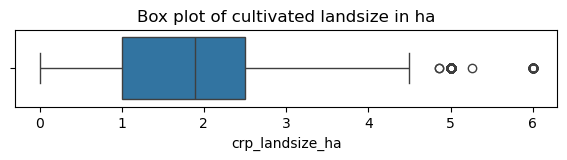

In [14]:
# Check for outlier
# Create a boxplot to visualize distribution of `crp_landsize_ha`

plt.figure(figsize=(7,1))
sns.boxplot(df["crp_landsize_ha"], orient="h");
plt.title("Box plot of cultivated landsize in ha");

* The boxplot reveals there are some outlier in the dataset. The value begins from land size greater than 4.5 ha. Considering the scope of this survey, it sensible for a household to cultivate more than 6 ha. For instance, a family with large size.

In [15]:
# # Check and Handle outlier
# Q1 = df["crp_landsize_ha"].quantile(0.25)
# Q3 = df["crp_landsize_ha"].quantile(0.75)

# iqr = Q3 - Q1
# upper_limit = Q3 + 1.5 * iqr

# df.loc[df["crp_landsize_ha"] > upper_limit, "crp_landsize_ha"] = upper_limit

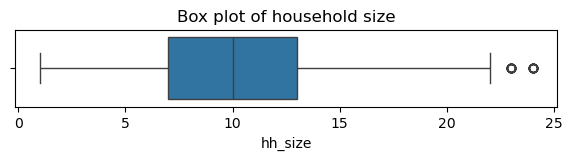

In [16]:
# Create a boxplot to visualize distribution of `hh_size`

plt.figure(figsize=(7,1))
sns.boxplot(df["hh_size"], orient="h");
plt.title("Box plot of household size");

In [17]:
# # Check and Handle outlier
# Q1 = df["hh_size"].quantile(0.25)
# Q3 = df["hh_size"].quantile(0.75)

# iqr = Q3 - Q1
# upper_limit = Q3 + 1.5 * iqr

# df.loc[df["hh_size"] > upper_limit, "hh_size"] = upper_limit

### Data Preparation

In [18]:
# df.info()

In [19]:
df.shape

(3438, 47)

 Check the balance of the dependent variable

In [20]:
df["FI_0_3"].value_counts(normalize=True)

FI_0_3
1    0.890343
0    0.109657
Name: proportion, dtype: float64

Quick inspection of the some of the new variables

In [21]:
# 1. Check count of professionals and non-professionals
print(df['need'].value_counts())

# 2. Check in-class churn rate
df.groupby(['need'])['FI_0_6'].value_counts(normalize=True)

need
Yes    3236
No      149
Name: count, dtype: int64


need  FI_0_6
No    0         0.510067
      1         0.489933
Yes   0         0.583745
      1         0.416255
Name: proportion, dtype: float64

The food insecurity status of household with more than one income 88 percent, while that of household without is 89 percent. This doesn't seem to have a predictive power. 

### Create Dummy Variables

There is need to create dummy variables for variables that are categorical.

In cases with many categorical variables, you can use pandas built-in [`pd.get_dummies()`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html), or  scikit-learn's [`OneHotEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) function.

**Note:** Variables with many categories should only be dummied if absolutely necessary. Each category will result in a coefficient for your model which can lead to overfitting.

Because this dataset only has some variables with only two levels, it's not necessary to use one of these special functions. We just apply transformation directly.


In [147]:
df.head()

,state,hh_agricactivity,hh_gender,hh_education,hh_size,hh_maritalstat_clean,hh_age,crp_landsize_ha,resp_islsproducer,resp_iscropproducer,crp_main,crp_salesprice,wealth_quintile,hh_wealth_water,hh_wealth_toilet,hh_wealth_light,income_comp_clean,income_more_than_one,income_main_cat,income_main_gender,shock_noshock,need,any_salediff,any_proddiff,any_dif,shock_drought,shock_flood,shock_plantdisease,shock_pestoutbreak,shock_animaldisease,shock_violenceinsecconf,shock_higherfoodprices,shock_higherfuelprices,crp_proddif_access_fertilize,FI_0,FI_0_3,FI_0_6,fies_rawscore,weight_final
0,Zamfara,crop production,Male,Religious Education,18.0,Married,41 to 65,4.0,No,Yes,Maize,A lot less,Middle,2.0,2.0,1.0,Decrease,Yes,Non Agricultural employment,1.0,0.0,Yes,Yes,Yes,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,1,1,8.0,0.198500
1,Zamfara,crop and livestock production,Male,Primary Education,9.0,Married,41 to 65,1.0,Yes,Yes,Sorghum,NaN,Low,2.0,2.0,4.0,Increase,No,Non Agricultural employment,1.0,0.0,Yes,No,Yes,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1,1,1,8.0,0.187787
2,Zamfara,crop and livestock production,Male,Primary Education,19.0,Married,41 to 65,1.0,Yes,Yes,Sorghum,NaN,Low,2.0,2.0,4.0,Increase,No,Agricultural employment,1.0,0.0,Yes,Yes,Yes,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1,1,1,8.0,0.187787
3,Zamfara,crop production,Male,Religious Education,14.0,Married,41 to 65,3.0,No,Yes,Beans,A lot more,Middle,2.0,2.0,1.0,Decrease,No,Agricultural employment,3.0,0.0,Yes,Yes,Yes,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,1,1,8.0,0.198500
4,Zamfara,crop production,Male,Higher Education,12.0,Married,41 to 65,3.0,No,Yes,Maize,A lot more,Middle,2.0,2.0,1.0,Decrease,Yes,Agricultural employment,1.0,0.0,Yes,Yes,Yes,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1,1,1,7.0,0.198500


## Model Building

In [22]:

df.to_csv("../data/26052024_model_ready_data", index=False)

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3438 entries, 0 to 3437
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   state                         3438 non-null   object 
 1   hh_agricactivity              3438 non-null   object 
 2   hh_gender                     3438 non-null   object 
 3   hh_education                  3438 non-null   object 
 4   hh_size                       3438 non-null   float64
 5   hh_maritalstat_clean          3438 non-null   object 
 6   hh_age                        3438 non-null   object 
 7   crp_landsize_ha               3438 non-null   float64
 8   resp_islsproducer             3438 non-null   object 
 9   resp_iscropproducer           3438 non-null   object 
 10  crp_main                      3438 non-null   object 
 11  crp_salesprice                2523 non-null   object 
 12  wealth_quintile               3435 non-null   object 
 13  hh_

In [126]:
df.columns

Index(['state', 'hh_agricactivity', 'hh_gender', 'hh_education', 'hh_size',
       'hh_maritalstat_clean', 'hh_age', 'crp_landsize_ha',
       'resp_islsproducer', 'resp_iscropproducer', 'crp_main',
       'crp_salesprice', 'wealth_quintile', 'hh_wealth_water',
       'hh_wealth_toilet', 'hh_wealth_light', 'income_comp_clean',
       'income_more_than_one', 'income_main_cat', 'income_main_gender',
       'shock_noshock', 'need', 'any_salediff', 'any_proddiff', 'any_dif',
       'shock_drought', 'shock_flood', 'shock_plantdisease',
       'shock_pestoutbreak', 'shock_animaldisease', 'shock_violenceinsecconf',
       'shock_higherfoodprices', 'shock_higherfuelprices',
       'crp_proddif_access_fertilize', 'FI_0', 'FI_0_3', 'FI_0_6',
       'fies_rawscore', 'weight_final'],
      dtype='object')

In [127]:

# data.exog = sm.add_constant(df[["shock_drought", 
#                                 "shock_flood", 
#                                 "shock_plantdisease",
#                                "shock_animaldisease",
#                                "shock_violenceinsecconf",
#                                "income_main_gender",
#                                "any_salediff"
#                                ]])
# data.endog = df["FI_0_3"]

formula = "FI_0_3 ~ shock_drought + shock_flood + shock_plantdisease + shock_animaldisease + \
shock_violenceinsecconf + C(income_main_gender)+ wealth_quintile+ hh_agricactivity+\
hh_education+hh_size + crp_landsize_ha + hh_age"

mod = smf.glm(formula,
              data=df,
             family=sm.families.Binomial(),
             var_weights = df["weight_final"],
             missing="drop"
            )

res = mod.fit()

res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 FI_0_3   No. Observations:                 3323
Model:                            GLM   Df Residuals:                     3301
Model Family:                Binomial   Df Model:                           21
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1117.9
Date:                Wed, 29 May 2024   Deviance:                       2235.9
Time:                        06:42:04   Pearson chi2:                 3.22e+03
No. Iterations:                     7   Pseudo R-squ. (CS):            0.09994
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             1.0194      0.339      3.008      0.003       0.355       1.684
C(income_main_gender)[T.2.0]                          0.7444      0.405      1.838      0.066      -0.049       1.538
C(income_main_gender)[T.3.0]                          0.3121      0.201      1.550      0.121      -0.082       0.707
wealth_quintile[T.Highest]                            0.8949      0.138      6.497      0.000       0.625       1.165
wealth_quintile[T.Low]                                1.1796      0.166      7.104      0.000       0.854       1.505
wealth_quintile[T.Middle]                             1.3521      0.185      7.316      0.000       0.990       1.714
hh_agricactivity[T.crop and livestock production]    -0.3161      0.336     -0.940      0.347      -0.975       0.343
hh_agricactivity[T.crop production]                   0.2785      0.341      0.816      0.414      -0.390       0.947
hh_agricactivity[T.livetock production]              -0.6776      0.392     -1.730      0.084      -1.445       0.090
hh_education[T.No Education]                          0.6786      0.227      2.985      0.003       0.233       1.124
hh_education[T.Primary Education]                     0.8824      0.200      4.421      0.000       0.491       1.274
hh_education[T.Religious Education]                   0.7110      0.148      4.808      0.000       0.421       1.001
hh_education[T.Secondary Education]                   0.2805      0.153      1.832      0.067      -0.020       0.581
hh_age[T.41 to 65]                                    0.1084      0.128      0.845      0.398      -0.143       0.360
hh_age[T.Over 65]                                     0.0515      0.495      0.104      0.917      -0.919       1.022
shock_drought                                         1.0926      0.361      3.026      0.002       0.385       1.800
shock_flood                                          -0.1249      0.330     -0.379      0.705      -0.772       0.522
shock_plantdisease                                    1.8098      0.347      5.219      0.000       1.130       2.489
shock_animaldisease                                  -0.2030      0.288     -0.705      0.481      -0.768       0.362
shock_violenceinsecconf                               0.9582      0.187      5.118      0.000       0.591       1.325
hh_size                                              -0.0229      0.013     -1.712      0.087      -0.049       0.003
crp_landsize_ha                                      -0.2029      0.043     -4.724      0.000      -0.287      -0.119
=====================================================================================================================
"""

In [128]:
df["income_main_gender"]

0       1.0
1       1.0
2       1.0
3       3.0
4       1.0
       ... 
3433    1.0
3434    1.0
3435    1.0
3436    1.0
3437    1.0
Name: income_main_gender, Length: 3438, dtype: float64